In [1]:
import seaborn
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem as Chem

from scipy.spatial import distance
from sklearn import manifold

import pandas as pd
import molvs
import csv
from pprint import pprint

# Reading the data

In [2]:
CB1_data = []
with open("Cannabinoid_CB1_receptor.csv") as f:
    reader = csv.reader(f, delimiter = ";", quotechar = '"')
    for line in reader:
        #print(line)
        CB1_data.append(line)
header = CB1_data[0]
CB1_data = CB1_data[1:]
CB1_data[0]

['CHEMBL394295',
 'Cc1ccc(cc1)c2ncc(nc2c3ccc(C)cc3)C(=O)N[C@@H]4CCCC[C@H]4CO',
 'Ki',
 '50',
 '7.3',
 '415.54',
 '4.71']

In [13]:
CB1_smiles = [r[1] for r in CB1_data]
CB1_smiles[:5], len(CB1_smiles)

(['Cc1ccc(cc1)c2ncc(nc2c3ccc(C)cc3)C(=O)N[C@@H]4CCCC[C@H]4CO',
  'C\\N=C(/NS(=O)(=O)c1ccc(cc1)C(F)(F)F)\\N2C[C@@H](C(=N2)c3ccc(Cl)cc3)c4ccccc4',
  'CCCCCC1=NN(CC1c2ccccc2)C(=O)NC3CCCc4ccccc34',
  'CCCCCCC(C)(C)c1ccc(c(O)c1)c2cccc(OC)c2',
  'OC1CCCCC1NC(=O)c2cn(c3ccc(Cl)cc3)c(n2)c4ccc(Cl)cc4Cl'],
 2416)

In [12]:
CB1_mols = [Chem.MolFromSmiles(s) for s in CB1_smiles if s]
CB1_mols[:5], len(CB1_mols)

([<rdkit.Chem.rdchem.Mol at 0x7f89f9f38760>,
 2332)

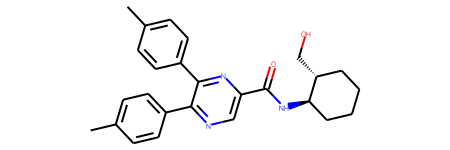

In [5]:
CB1_mols[0]

In [6]:
ZINC_smiles = []
with open("zincs1000.smi") as f:
    for line in f:
        ZINC_smiles.append(line.strip("\n"))

ZINC_smiles[:5]

['CN(C)CC(=O)NCc1cccc(OCc2ccccc2)c1',
 'CSCCN1CCC(C(=O)c2ccc3c(c2)NC(=O)C(C)O3)CC1',
 'CC(=O)N1CCCCC1C(=O)NC1CCCN(c2ncccn2)C1',
 'CNC(=O)C1(C)CCN(C(=O)c2csc(-c3cnn(-c4ccccc4)c3)n2)C1',
 'Fc1ccc2nc(-c3cccc(Cl)c3)sc2c1']

In [11]:
ZINC_mols = [Chem.MolFromSmiles(s) for s in ZINC_smiles if s]
ZINC_mols[0], len(ZINC_mols)

(<rdkit.Chem.rdchem.Mol at 0x7f89f9f59b20>, 1000)

# Standardization

In [18]:
isOrganic = Chem.MolFromSmarts('[#6]')
hasInorganic = Chem.MolFromSmarts('[!#6;!#7;!#8;!#16;!Cl;!F;!Br;!I]')

_s = molvs.Standardizer()
def standardisation(mol):
    mol = _s.standardize(mol)
    mol = _s.fragment_parent(mol)
    if mol.HasSubstructMatch(isOrganic) and not mol.HasSubstructMatch(hasInorganic):
        mol = _s.charge_parent(mol)
        mol = _s.stereo_parent(mol)
        return mol
    else:
        return None

In [22]:
CB1_supp = (standardisation(mol) for mol in CB1_mols if mol)
CB1_clean = [mol for mol in CB1_supp if mol]
len(CB1_clean)

2331

In [23]:
ZINC_supp = (standardisation(mol) for mol in ZINC_mols if mol)
ZINC_clean = [mol for mol in ZINC_supp if mol]
len(ZINC_clean)

1000

# Descriptors

I'll be using TPSA and clogP for the visulization.

In [65]:
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors
from matplotlib import pyplot as plt

In [104]:
CB1_descriptors = [[Descriptors.MolLogP(m), rdMolDescriptors.CalcTPSA(m), True] for m in CB1_clean]
CB1_descriptors = pd.DataFrame(CB1_descriptors, columns = ["cLogP", "TPSA", "isCB1"])

In [42]:
ZINC_descriptors = [[Descriptors.MolLogP(m), rdMolDescriptors.CalcTPSA(m), False] for m in ZINC_clean]
ZINC_descriptors = pd.DataFrame(ZINC_descriptors, columns = ["cLogP", "TPSA", "isCB1"])

In [62]:
all_descriptors = pd.concat([ZINC_descriptors, CB1_descriptors])

Text(0, 0.5, 'TPSA')

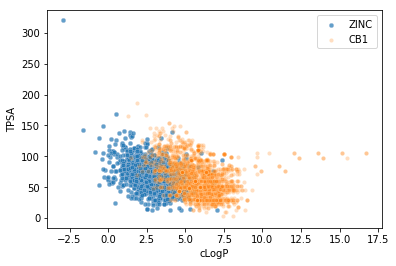

In [127]:
plt.scatter(ZINC_descriptors["cLogP"], ZINC_descriptors["TPSA"], edgecolors="lightsteelblue", linewidths=0.5, alpha=0.7, s=20, label="ZINC")
plt.scatter(CB1_descriptors["cLogP"], CB1_descriptors["TPSA"], edgecolors="navajowhite", linewidths=0.5, alpha=0.25, s=15, label="CB1")
plt.legend()
plt.xlabel("cLogP")
plt.ylabel("TPSA")
